In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import os
import seaborn as sns

from collections import defaultdict
from scipy.stats import pearsonr, spearmanr, kendalltau
from glob import glob

from correlations import *

In [2]:
!ls ../datasets/summ_data/REALSumm/quantile/regression

all.csv		       dev.rescaled_1_50.csv  test.rescaled_1_50.csv
all.rescaled_1_50.csv  statistics	      train.csv
dev.csv		       test.csv		      train.rescaled_1_50.csv


In [3]:
TARGET_COL = "target_rescaled"
DATASET_NAME = "realsumm"
DATASET_DIR = "../datasets/summ_data/REALSumm/quantile/regression"

dfs = []
for split in ("all", "train", "dev", "test"):
    df = pd.read_csv(f"{DATASET_DIR}/{split}.rescaled_1_50.csv")
    for col in ("bert_score_p", "bert_score_r", "bert_score_f"):
        if col in df.columns:
            df[col] = df[col].apply(lambda s: s.replace("tensor", "")[1:-1]).apply(float)
    df["len_sys_summ"] = df["sys_summ"].apply(lambda s: len(s.split(" ")))
    dfs.append(df)
    
all_df, train_df, dev_df, test_df = dfs

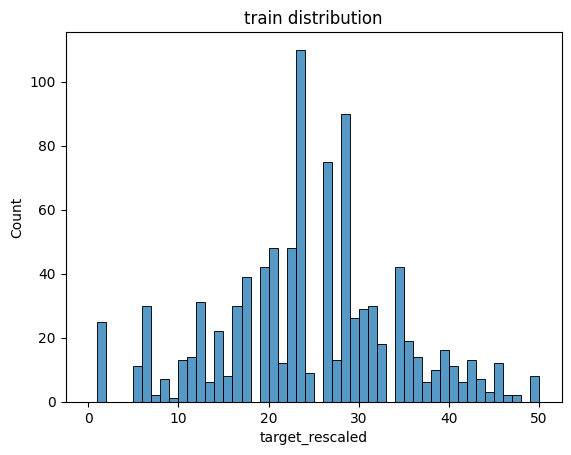

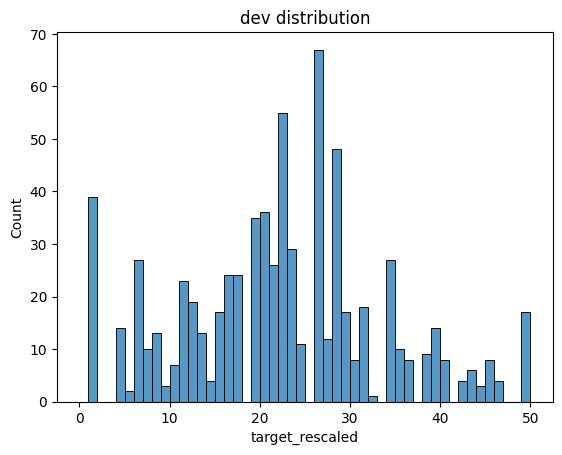

In [4]:
sns.histplot(data=train_df, x="target_rescaled", bins=50, binrange=(0, 50))
plt.title("train distribution")
plt.show()
sns.histplot(data=dev_df, x="target_rescaled", bins=50, binrange=(0, 50))
plt.title("dev distribution")
plt.show()

In [5]:
train_df.sort_values(["bartscore_doc_id", "target_rescaled", "sys_name"]).to_csv("REALSUMM.train_df.csv")
dev_df.sort_values(["bartscore_doc_id", "target_rescaled", "sys_name"]).to_csv("REALSUMM.dev_df.csv")

In [6]:
def get_extremes_for_metric(data, metric, by="bartscore_doc_id", k=5):
    # bartscore_doc_id uniquely identifies each document id 
    scores_std = data.groupby(by).std()[metric].sort_values()
    low_std_top = scores_std.head(k).index.tolist()
    high_std_top = scores_std.tail(k).index.tolist()
    print("Documents (with lower score diversity):", low_std_top)
    print("Documents (with higher score diversity):", high_std_top)
    print()

    return low_std_top, high_std_top 

## Correlations

In [7]:
METRICS = [
    # BERTScore
    'bert_score_p','bert_score_r','bert_score_f',
    'mover_score',
    # PRISM
    'prism_ref_hypo','prism_hypo_ref','prism_avg','prism_src_hypo',
    # ROUGE
    'rouge1_r','rouge1_p','rouge1_f',
    'rouge2_r','rouge2_p','rouge2_f',
    'rougel_r','rougel_p','rougel_f',
    # BARTScore
    'bart_score_cnn_ref_hypo_en', 'bart_score_cnn_ref_hypo_de',
    'bart_score_cnn_hypo_ref_en','bart_score_cnn_hypo_ref_de',
    'bart_score_cnn_avg_f_en','bart_score_cnn_avg_f_de',
    'bart_score_cnn_harm_f_en','bart_score_cnn_harm_f_de',
    'bart_score_src_hypo','bart_score_hypo_ref','bart_score_ref_hypo','bart_score_avg_f','bart_score_harm_f',
    'bart_score_cnn_src_hypo','bart_score_cnn_hypo_ref','bart_score_cnn_ref_hypo','bart_score_cnn_avg_f','bart_score_cnn_harm_f',
    'bart_score_para_src_hypo','bart_score_para_hypo_ref','bart_score_para_ref_hypo','bart_score_para_avg_f','bart_score_para_harm_f',
]
systems = sorted(all_df["sys_name"].unique())

instance_baseline_corrs = []
system_baseline_corrs = []
        
print("-" * 80)
print("Computing correlations for AUTOMATED METRICS")
print("-" * 80)

instance_corr_metrics = compute_instance_level_correlations(
    dev_df,
    metrics=METRICS + ["len_sys_summ"],
    target_col=TARGET_COL,
    dataset_name=f"{DATASET_NAME.lower()}",
    output_dir="",
    to_persist=False,
)

system_corr_metrics = compute_system_level_correlations(
    dev_df, 
    metrics=METRICS + ["len_sys_summ"],
    target_col=TARGET_COL,
    dataset_name=f"{DATASET_NAME.lower()}",
    output_dir="",
    systems=systems,
    to_persist=False
)

--------------------------------------------------------------------------------
Computing correlations for AUTOMATED METRICS
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col


In [8]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).head(10)

,pearsonr,spearmanr,kendalltau
rouge1_r,0.505754,0.495660,0.408431
rougel_r,0.491844,0.483612,0.399427
bart_score_para_hypo_ref,0.476536,0.460115,0.361451
bart_score_cnn_hypo_ref_de,0.440618,0.450739,0.355831
bert_score_r,0.467604,0.442485,0.350874
bart_score_cnn_hypo_ref,0.441086,0.437499,0.343625
bart_score_cnn_hypo_ref_en,0.441866,0.438543,0.343379
bart_score_hypo_ref,0.448012,0.430565,0.333707
rouge2_r,0.397907,0.395407,0.329546
prism_hypo_ref,0.435790,0.404335,0.325782


<AxesSubplot:>

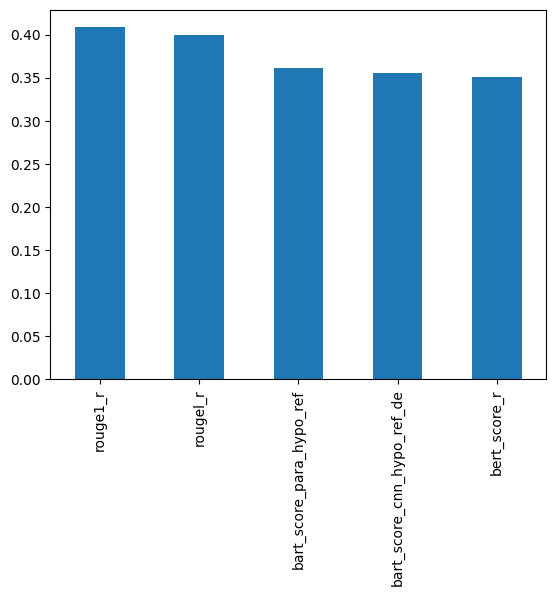

In [9]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).head()["kendalltau"].plot(kind="bar")

<AxesSubplot:>

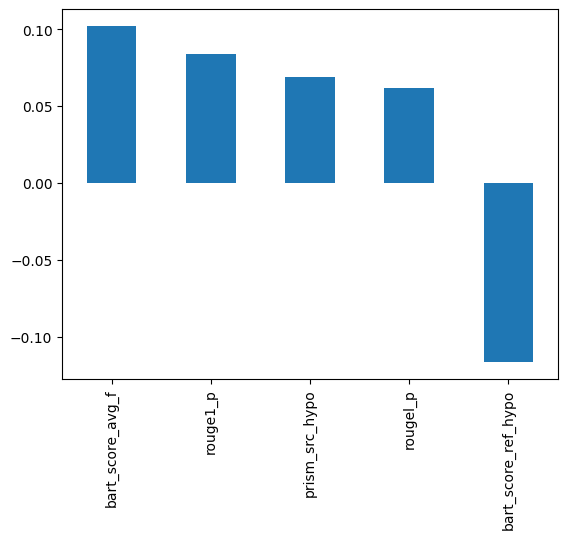

In [10]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).tail()["kendalltau"].plot(kind="bar")

In [11]:
system_corr_metrics.sort_values("kendalltau", ascending=False).head(10)

,pearsonr,spearmanr,kendalltau
rouge2_r,0.8248,0.8741,0.7151
rougel_r,0.7699,0.7967,0.6207
rouge1_r,0.7914,0.8171,0.6207
bart_score_cnn_hypo_ref_de,0.6579,0.7641,0.5917
bart_score_cnn_hypo_ref_en,0.6645,0.7641,0.5917
bart_score_cnn_hypo_ref,0.6660,0.7767,0.5917
bart_score_para_hypo_ref,0.6546,0.7267,0.5771
bart_score_hypo_ref,0.7073,0.6541,0.4828
prism_hypo_ref,0.5749,0.6267,0.4610
prism_avg,0.5357,0.6227,0.4537


<AxesSubplot:>

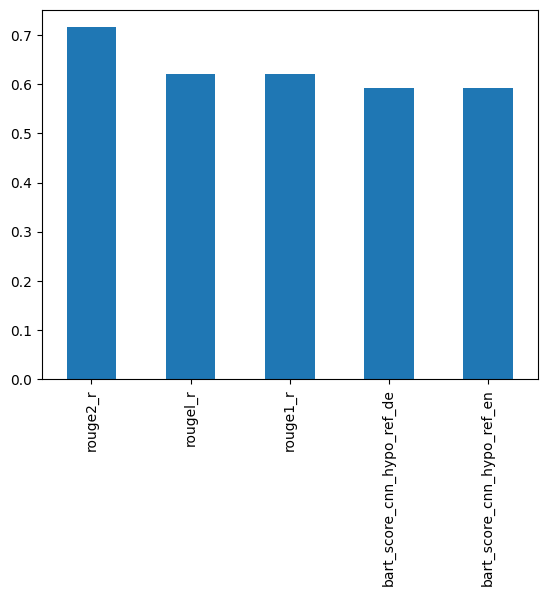

In [12]:
system_corr_metrics.sort_values("kendalltau", ascending=False).head()["kendalltau"].plot(kind="bar")

<AxesSubplot:>

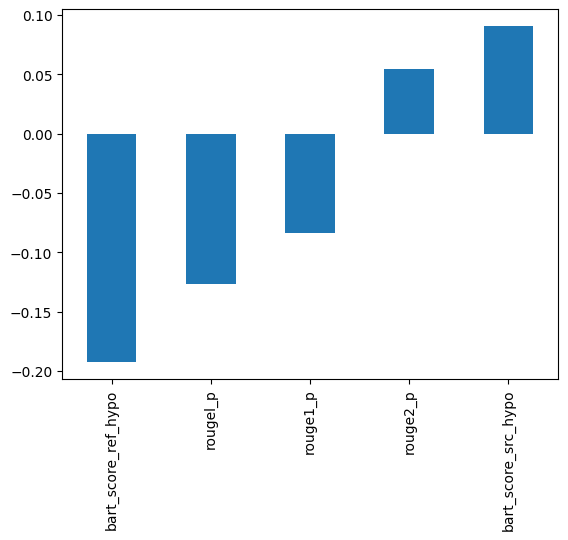

In [13]:
system_corr_metrics.sort_values("kendalltau").head()["kendalltau"].plot(kind="bar")

In [15]:
def compute_metrics(df: pd.DataFrame):
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
    from scipy.stats import pearsonr, spearmanr, kendalltau
    
    metrics = {}
    
    num_correct = 0
    num_digits = 0
    errs_p, errs_t, errs, mae, mse = [], [], [], [], []
    for p, t in zip(df["prediction"], df["label"]):
        # label is already a number
        p = str(p) if isinstance(p, (int, float)) else p
        p = p.strip()

        num_correct += (p == str(t))
        num_digits += p.isdigit()

        if not p.isdigit():
            continue

        p, t = float(p), float(t)
        err = (t - p)
        errs_p.append(p)
        errs_t.append(t)
        errs.append(err)
        mae.append(np.abs(err))
        mse.append(err * err)
    
    metrics["accuracy"] = num_correct / len(df)
    metrics["digits_count"] = num_digits
    metrics["digits_pct"] = num_digits / len(df)

    metrics["err_len"] = len(errs)
    metrics["err_avg"] = float(np.mean(errs))
    metrics["mae_avg"] = float(np.mean(mae))
    metrics["mse_avg"] = float(np.mean(mse))

    metrics["err_std"] = float(np.std(errs))
    metrics["mae_std"] = float(np.std(mae))
    metrics["mse_std"] = float(np.std(mse))
    
    return metrics

Find 22 experiments



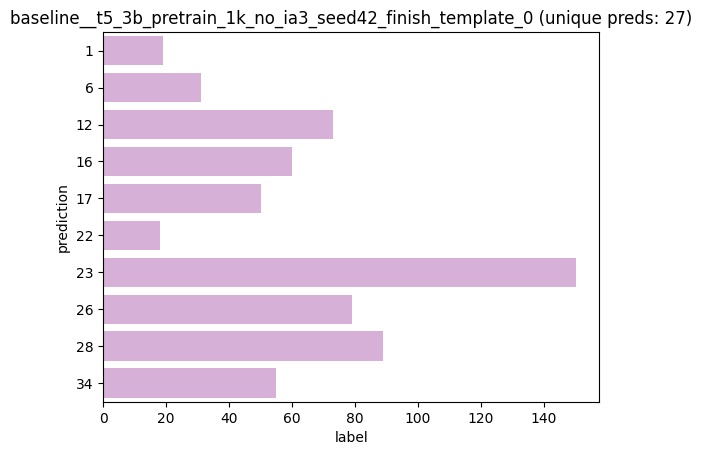

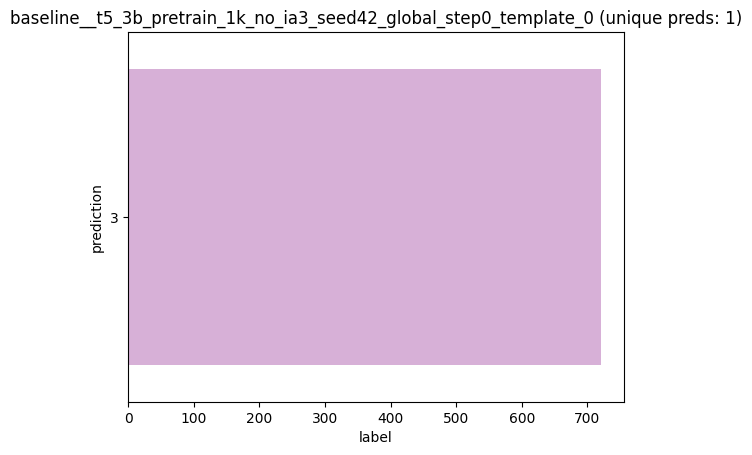

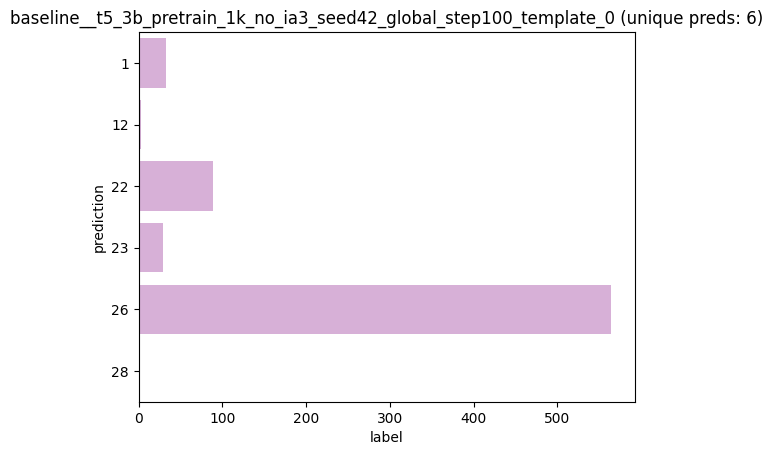

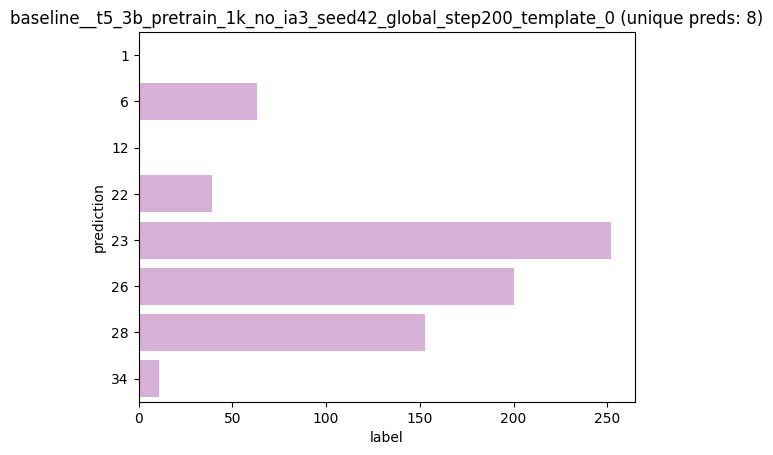

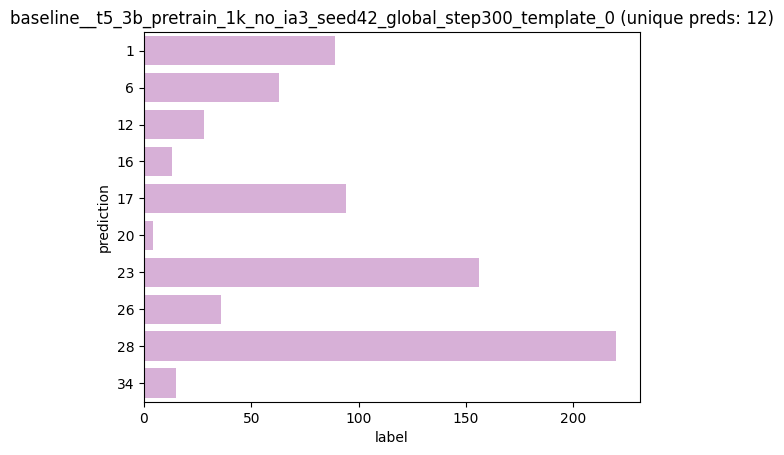

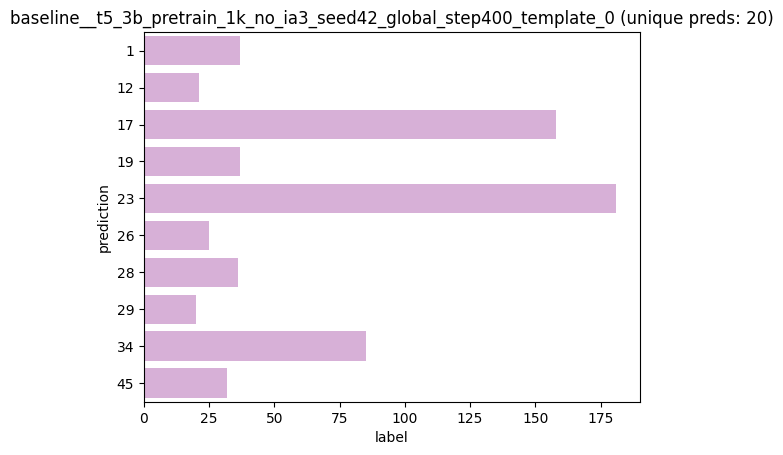

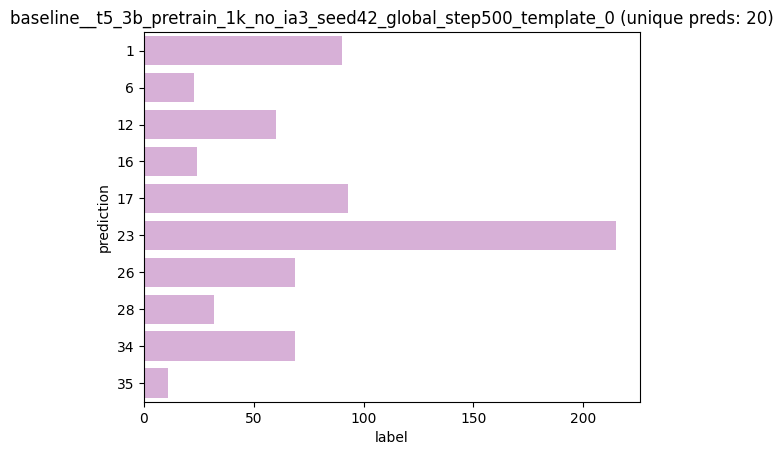

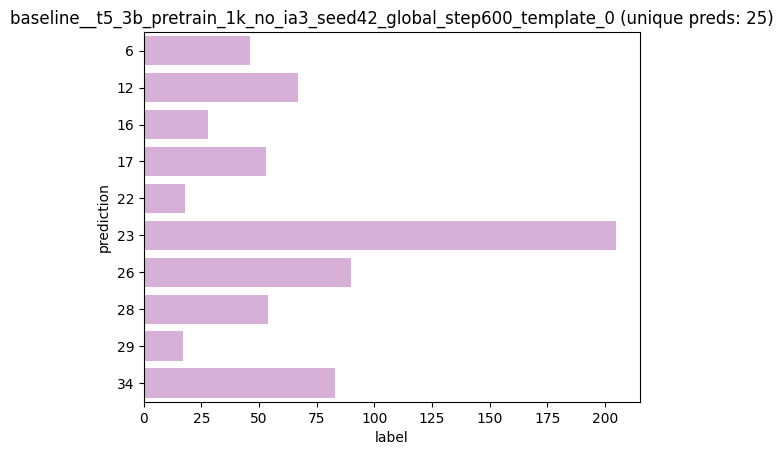

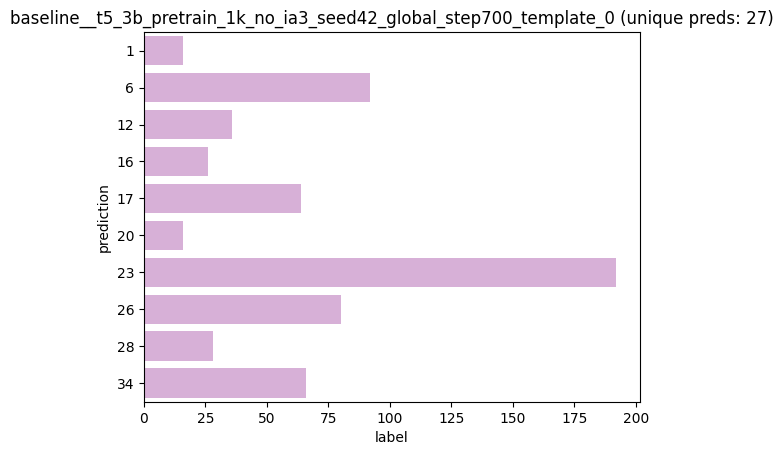

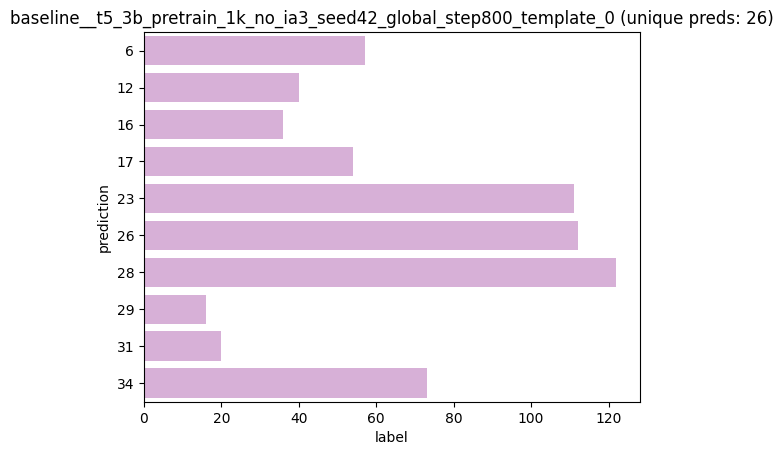

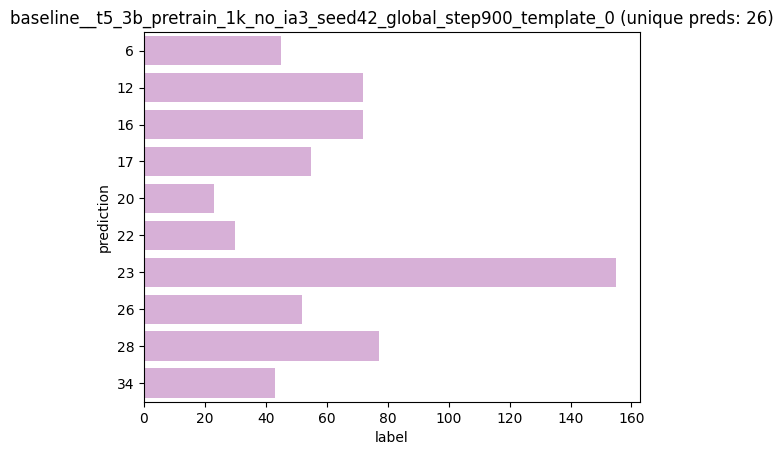

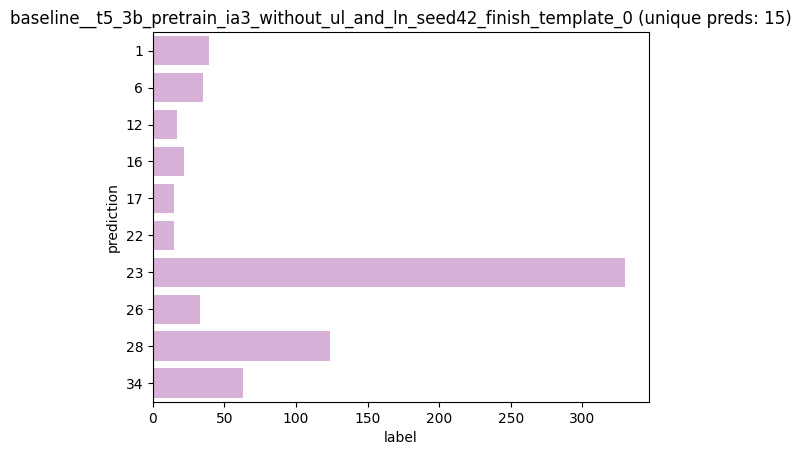

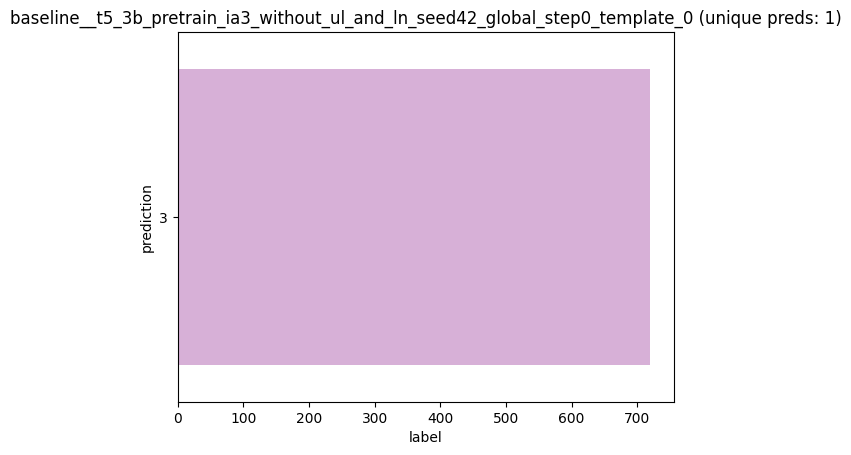

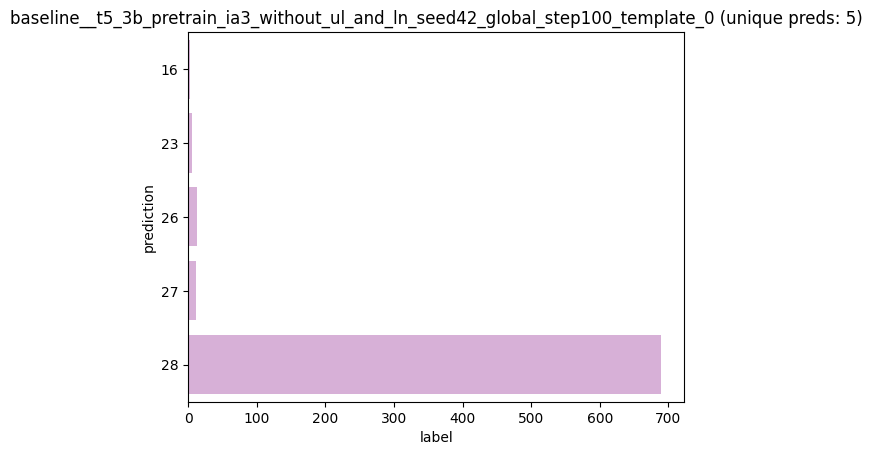

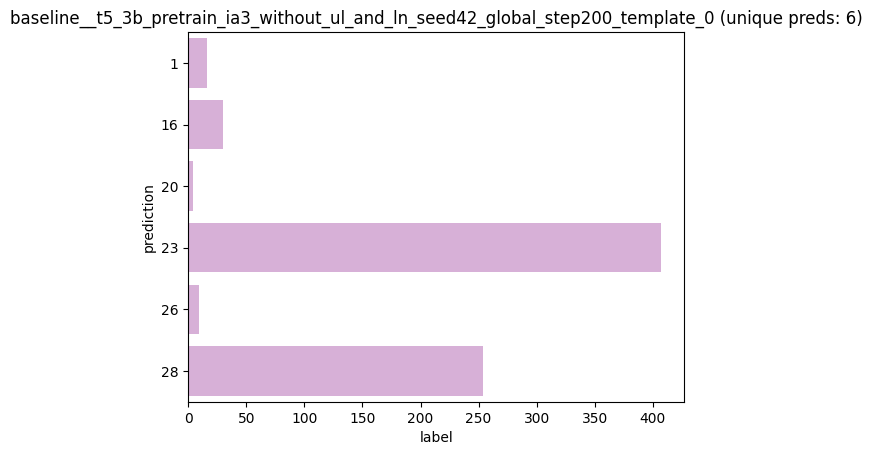

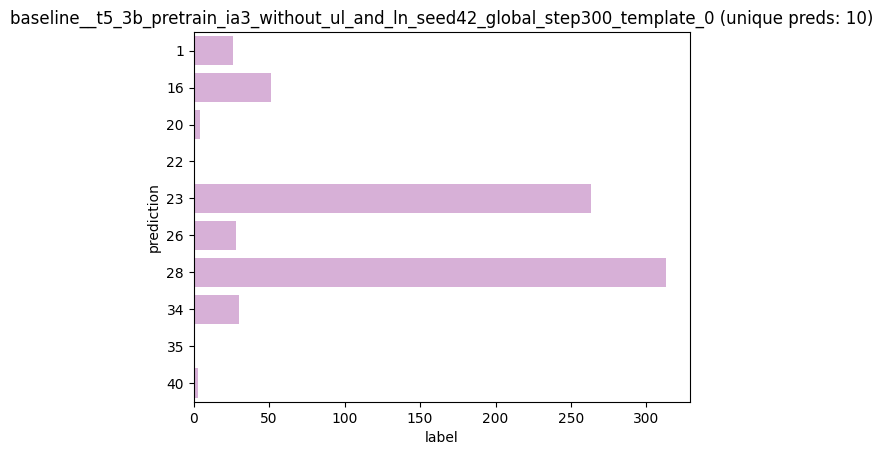

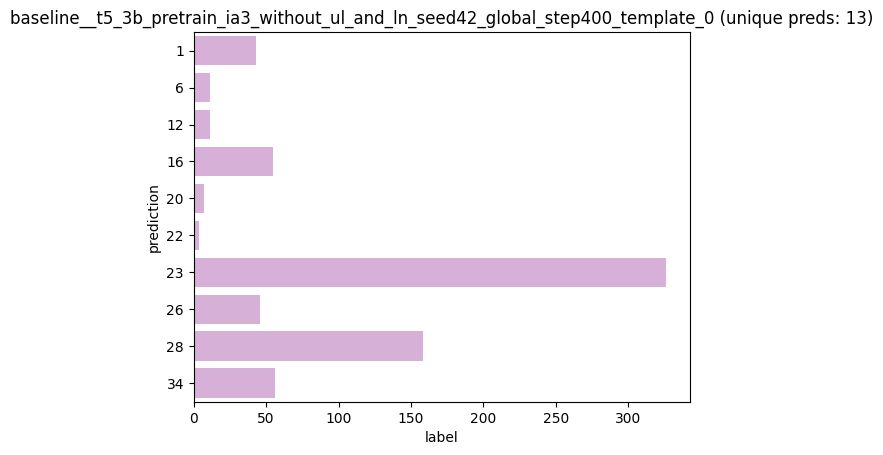

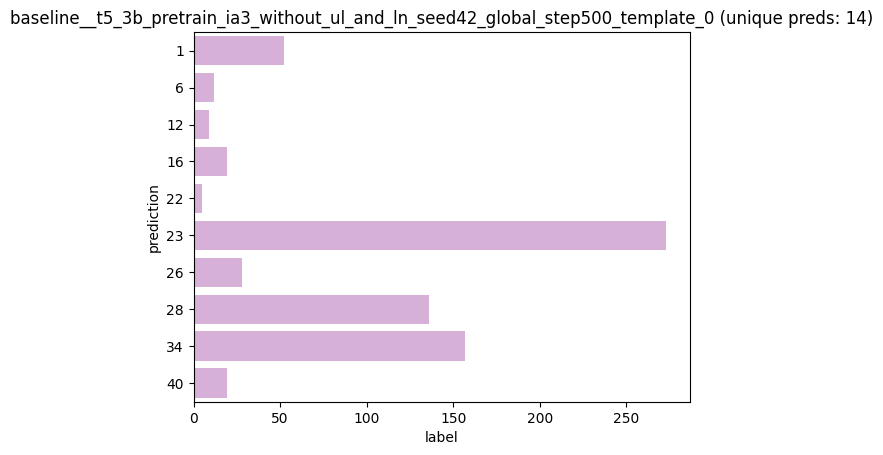

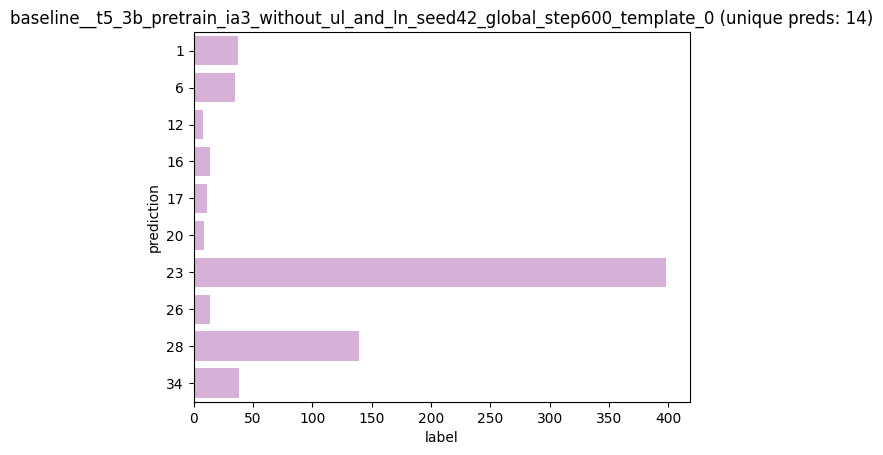

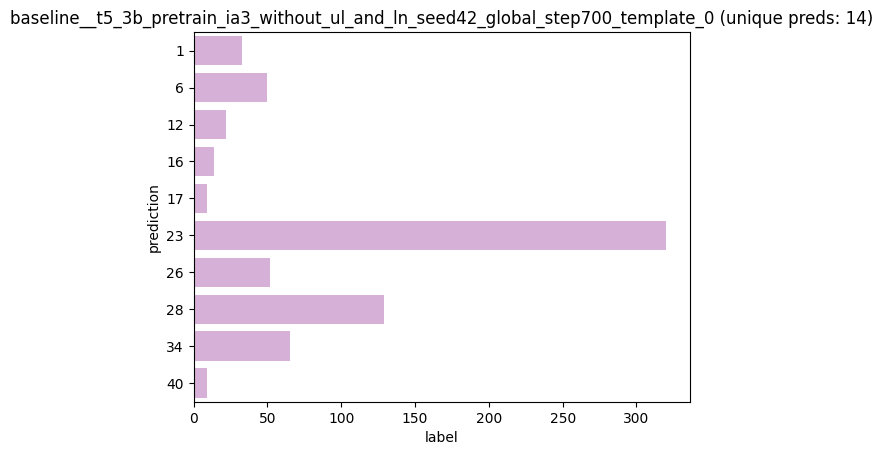

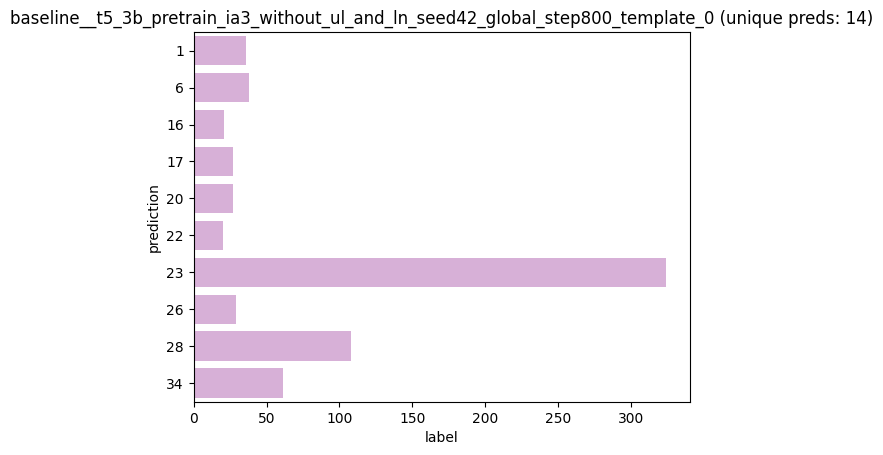

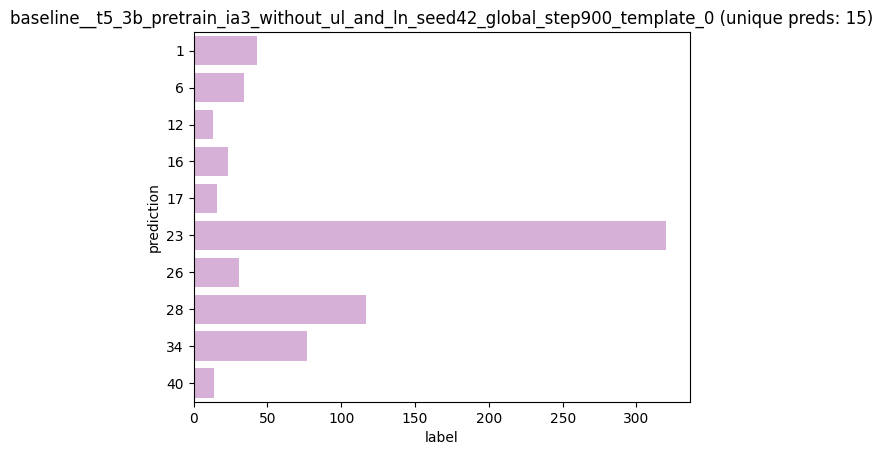

,accuracy,digits_count,digits_pct,err_len,err_avg,mae_avg,mse_avg,err_std,mae_std,mse_std,baseline
0,0.090278,720,1.0,720,0.154167,7.843056,108.462500,10.413392,6.851933,193.530270,baseline__t5_3b_pretrain_1k_no_ia3_seed42_fini...
1,0.000000,720,1.0,720,18.961111,19.177778,487.352778,11.306151,10.934606,486.165976,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...
2,0.116667,720,1.0,720,-2.225000,8.819444,129.586111,11.164026,7.197466,173.161368,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...
3,0.097222,720,1.0,720,-1.515278,8.237500,120.212500,10.858933,7.235751,205.470965,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...
4,0.076389,720,1.0,720,2.595833,8.534722,131.770833,11.181792,7.676545,255.559031,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...
5,0.080556,720,1.0,720,-1.086111,8.830556,135.775000,11.601524,7.602387,255.114499,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...
6,0.079167,720,1.0,720,1.988889,8.525000,132.797222,11.350839,7.753812,266.342533,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...
7,0.080556,720,1.0,720,-0.313889,8.186111,116.980556,10.811199,7.068815,207.397718,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...
8,0.066667,720,1.0,720,0.252778,8.563889,127.730556,11.298967,7.374982,229.750776,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...
9,0.081944,720,1.0,720,-1.213889,8.311111,119.850000,10.880095,7.125688,210.646649,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...


In [16]:
output_dir = f"../t-few-master/experiments_balanced/realsumm_reg/evals/dev"
dev_files = sorted(glob(os.path.join(output_dir, "*", "dev_pred.txt")))
print(f"Find {len(dev_files)} experiments")
print()

def extract_name(path):
    # Given a path in the format
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/<something>
    # 1. Extract the parent dir `t03b_realsumm_baseline_ft_train`
    exp_name = path.split("/")[-2]

    # 2. Keep all parts including baseline and afterwards
    # index_baseline = 0 
    index_baseline = exp_name.index("baseline")
    return exp_name[index_baseline:]


dev_data = {extract_name(path): pd.read_csv(path) for path in dev_files}

# Before returning the dataframe, we will recover the bartscore_doc_id
# to facilitate re-use of previous correlation methods.
metrics_reg = []
dev_baselines = {}
for baseline, data in dev_data.items():
    # data = data.merge(train_df, left_on="idx", right_on="index", suffixes=(None, "_orig"))
    data = data.merge(dev_df, left_on="idx", right_on="index", suffixes=(None, "_orig"))
    assert (data["label"] == data["target_rescaled"]).all()
    
    m = compute_metrics(data)
    m["baseline"] = baseline
    
    metrics_reg.append(m)
    
    counts = data.groupby(["prediction"]).count().sort_values("label", ascending=False).head(10)
    counts = counts.reset_index().sort_values("prediction")
    counts["prediction"] = counts["prediction"].apply(str)
    
    sns.barplot(y=counts["prediction"], x=counts["label"], orient="h", color="#ddaadd")
    plt.title(f"{baseline} (unique preds: {data['prediction'].nunique()})")
    plt.show()
    
    data["is_digit_prediction"] = data["prediction"].apply(lambda p: str(p).strip().isdigit())
    dev_baselines[baseline] = data
    
    # 
    data["log.pred_score"] = data["log.pred_score"].apply(lambda s: -1 * s)
    data["log.label"] = data["log.label"].apply(lambda s: -1 * s)

metrics_reg = pd.DataFrame(metrics_reg)
metrics_reg

In [17]:
train_df["target_rescaled"].value_counts()

23    110
28     90
26     75
20     48
22     48
34     42
19     42
17     39
12     31
31     30
6      30
16     30
30     29
29     26
1      25
14     22
35     19
32     18
39     16
36     14
11     14
42     13
10     13
27     13
45     12
21     12
40     11
5      11
38     10
24      9
50      8
15      8
43      7
8       7
13      6
41      6
37      6
44      3
7       2
47      2
46      2
9       1
Name: target_rescaled, dtype: int64

In [18]:
dev_df["target_rescaled"].value_counts()

26    67
22    55
28    48
1     39
20    36
19    35
23    29
6     27
34    27
21    26
16    24
17    24
11    23
12    19
31    18
50    17
15    17
29    17
4     14
39    14
8     13
13    13
27    12
24    11
7     10
35    10
38     9
40     8
45     8
36     8
30     8
10     7
43     6
42     4
46     4
14     4
9      3
44     3
5      2
32     1
Name: target_rescaled, dtype: int64

In [19]:
dataset_name = "realsumm"
# target_col = "litepyramid_recall"
target_col = "target_rescaled"
split_baselines = dev_baselines
systems = sorted(data["sys_name"].unique())

instance_baseline_corrs = []
system_baseline_corrs = []
        
for baseline, data in split_baselines.items():
    if data["is_digit_prediction"].all():
        
        print("\n" * 4)
        print("-" * 80)
        print("Computing correlations for", baseline)
        print("-" * 80)

        instance_corr = compute_instance_level_correlations(
            data,
            # metrics=["log.pred_score"],
            metrics=["prediction"],
            target_col=target_col,
            dataset_name=f"{dataset_name.lower()}_{baseline}",
            output_dir="",
            to_persist=False,
        )

        system_corr = compute_system_level_correlations(
            data, 
            # metrics=["log.pred_score"],
            metrics=["prediction"],
            target_col=target_col,
            dataset_name=f"{dataset_name.lower()}_{baseline}",
            output_dir="",
            systems=systems,
            to_persist=False
        )

        instance_corr["index"] = baseline
        system_corr["index"] = baseline

        instance_baseline_corrs.append(instance_corr)
        system_baseline_corrs.append(system_corr)

instance_baseline_corrs = pd.concat(instance_baseline_corrs)
system_baseline_corrs = pd.concat(system_baseline_corrs)






--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_finish_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step0_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step100_template_0
-----------------------------------

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/cbelem/miniconda3/envs/m

Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step300_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step400_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_globa

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step600_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step700_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_1k_no_ia3_seed42_globa

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/cbelem/miniconda3/envs/m






--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step100_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step200_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step300_

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step500_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step600_template_0
--------------------------------------------------------------------------------
Computing pearsonr with target_rescaled col
Computing spearmanr with target_rescaled col
Computing kendalltau with target_rescaled col





--------------------------------------------------------------------------------
Computing correlations for baseline__t5_3b_pretrai

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [20]:
def extract_template(name):
    template_no = name.rpartition("_")[-1]
    return template_no
    

def extract_basename(name):
    index = name.index("_template")
    name = name[:index]
    
    if "_seed" in name:
        index = name.index("_seed")
        name = name[:index]
    
    if "_global_step" in name:
        index = name.index("_global_step")
        name = name[:index]
    return name


def extract_seed(name):
    for s in name.split("_"):
        if "seed" in s:
            return s[4:]

    return "default"

def extract_modelname(name):
    for s in name.split("_"):
        if "finish" in s:
            steps = "1000"
            break
        elif "step" in s:
            steps = s
            break
    return steps.replace("step", "")


instance_baseline_corrs["eval_template"] = instance_baseline_corrs["index"].apply(extract_template)
instance_baseline_corrs["seed"] = instance_baseline_corrs["index"].apply(extract_seed)
instance_baseline_corrs["num_steps"] = instance_baseline_corrs["index"].apply(extract_modelname)
instance_baseline_corrs["num_epochs"] = instance_baseline_corrs["num_steps"].apply(lambda s: int(s) // 120)
instance_baseline_corrs["basename"] = instance_baseline_corrs["index"].apply(extract_basename)

system_baseline_corrs["eval_template"] = system_baseline_corrs["index"].apply(extract_template)
system_baseline_corrs["seed"] = system_baseline_corrs["index"].apply(extract_seed)
system_baseline_corrs["num_steps"] = system_baseline_corrs["index"].apply(extract_modelname)
system_baseline_corrs["num_epochs"] = system_baseline_corrs["num_steps"].apply(lambda s: int(s) // 120)
system_baseline_corrs["basename"] = system_baseline_corrs["index"].apply(extract_basename)

metrics_reg["num_steps"] = metrics_reg["baseline"].apply(extract_modelname)
metrics_reg["num_epochs"] = metrics_reg["num_steps"].apply(lambda s: int(s) // 120)
metrics_reg["seed"] = metrics_reg["baseline"].apply(extract_seed)
metrics_reg["basename"] = metrics_reg["baseline"].apply(extract_basename)
metrics_reg.head(2)

,accuracy,digits_count,digits_pct,err_len,err_avg,mae_avg,mse_avg,err_std,mae_std,mse_std,baseline,num_steps,num_epochs,seed,basename
0,0.090278,720,1.0,720,0.154167,7.843056,108.462500,10.413392,6.851933,193.530270,baseline__t5_3b_pretrain_1k_no_ia3_seed42_fini...,1000,8,42,baseline__t5_3b_pretrain_1k_no_ia3
1,0.000000,720,1.0,720,18.961111,19.177778,487.352778,11.306151,10.934606,486.165976,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,0,0,42,baseline__t5_3b_pretrain_1k_no_ia3


In [21]:
system_baseline_corrs.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau,index,eval_template,seed,num_steps,num_epochs,basename
prediction,0.7808,0.8240,0.6496,baseline__t5_3b_pretrain_1k_no_ia3_seed42_fini...,0,42,1000,8,baseline__t5_3b_pretrain_1k_no_ia3
prediction,0.7487,0.7634,0.5818,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,0,42,500,4,baseline__t5_3b_pretrain_1k_no_ia3
prediction,0.7213,0.7347,0.5600,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,0,42,400,3,baseline__t5_3b_pretrain_1k_no_ia3
prediction,0.7289,0.7181,0.5574,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,0,42,600,5,baseline__t5_3b_pretrain_ia3_without_ul_and_ln
prediction,0.6990,0.7175,0.5554,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,0,42,700,5,baseline__t5_3b_pretrain_1k_no_ia3


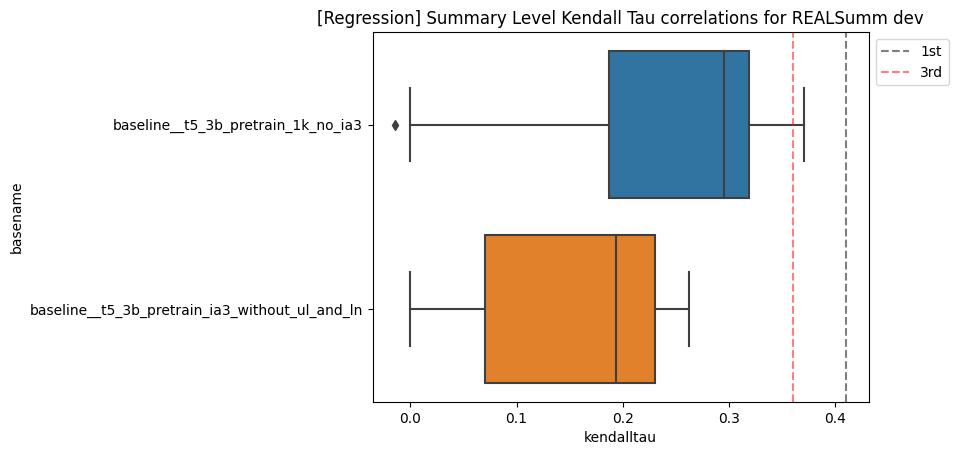

In [26]:
plt.title("[Regression] Summary Level Kendall Tau correlations for REALSumm dev")
sns.boxplot(data=instance_baseline_corrs, y="basename", x="kendalltau")

plt.axvline(x=0.41, color="black", label="1st", ls="--", alpha=0.5)
# plt.axvline(x=0.40, color="gray", label="rougel_r", ls="--", alpha=0.5)
plt.axvline(x=0.36, color="red", label="3rd", ls="--", alpha=0.5)


plt.legend(loc='upper left', bbox_to_anchor=(1.00, 1.00))
plt.show()

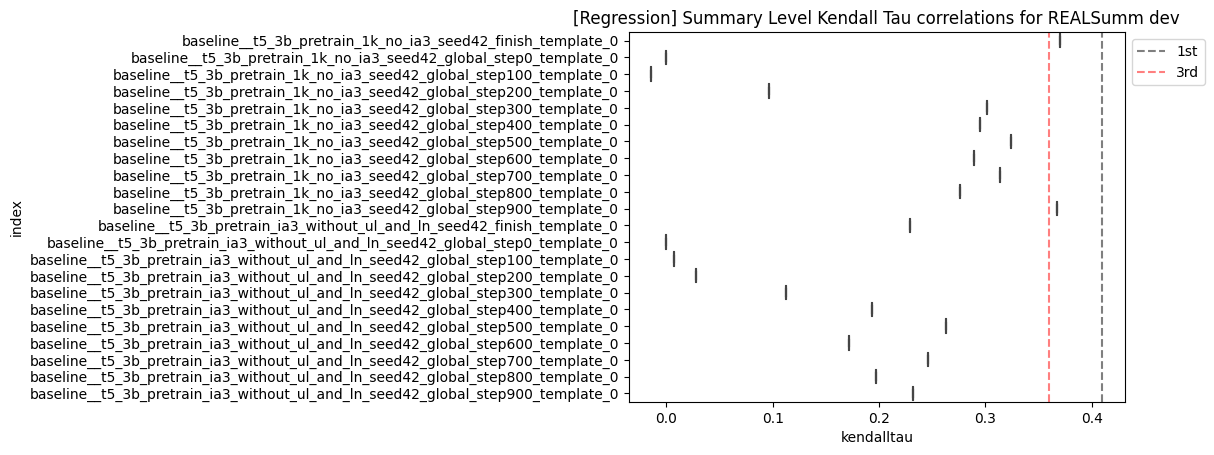

In [27]:
plt.title("[Regression] Summary Level Kendall Tau correlations for REALSumm dev")
sns.boxplot(data=instance_baseline_corrs, y="index", x="kendalltau")

plt.axvline(x=0.41, color="black", label="1st", ls="--", alpha=0.5)
# plt.axvline(x=0.40, color="gray", label="rougel_r", ls="--", alpha=0.5)
plt.axvline(x=0.36, color="red", label="3rd", ls="--", alpha=0.5)


plt.legend(loc='upper left', bbox_to_anchor=(1.00, 1.00))
plt.show()

In [29]:
instance_baseline_corrs.sort_values("kendalltau", ascending=False).head(10)[["basename", "num_epochs", "num_steps", "kendalltau"]]

,basename,num_epochs,num_steps,kendalltau
prediction,baseline__t5_3b_pretrain_1k_no_ia3,8,1000,0.370224
prediction,baseline__t5_3b_pretrain_1k_no_ia3,7,900,0.367814
prediction,baseline__t5_3b_pretrain_1k_no_ia3,4,500,0.324087
prediction,baseline__t5_3b_pretrain_1k_no_ia3,5,700,0.313906
prediction,baseline__t5_3b_pretrain_1k_no_ia3,2,300,0.301335
prediction,baseline__t5_3b_pretrain_1k_no_ia3,3,400,0.294918
prediction,baseline__t5_3b_pretrain_1k_no_ia3,5,600,0.289086
prediction,baseline__t5_3b_pretrain_1k_no_ia3,6,800,0.276537
prediction,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,4,500,0.262695
prediction,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,5,700,0.246548


In [30]:
system_baseline_corrs.sort_values("kendalltau", ascending=False).head()[["basename", "num_epochs", "num_steps", "kendalltau"]]

,basename,num_epochs,num_steps,kendalltau
prediction,baseline__t5_3b_pretrain_1k_no_ia3,8,1000,0.6496
prediction,baseline__t5_3b_pretrain_1k_no_ia3,4,500,0.5818
prediction,baseline__t5_3b_pretrain_1k_no_ia3,3,400,0.5600
prediction,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,5,600,0.5574
prediction,baseline__t5_3b_pretrain_1k_no_ia3,5,700,0.5554


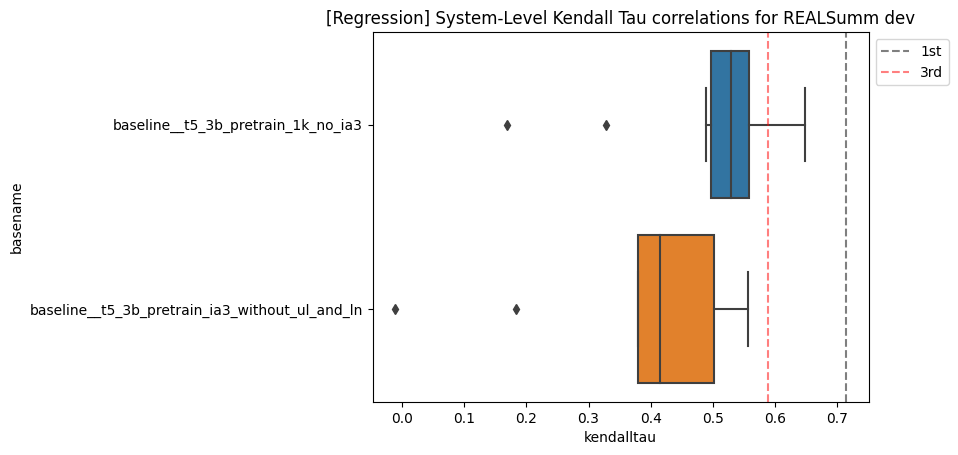

In [31]:
plt.title("[Regression] System-Level Kendall Tau correlations for REALSumm dev")
sns.boxplot(data=system_baseline_corrs, y="basename", x="kendalltau")

plt.axvline(x=0.7151, color="black", label="1st", ls="--", alpha=0.5)
# plt.axvline(x=0.62, color="gray", label="rougel_r", ls="--", alpha=0.5)
plt.axvline(x=0.59, color="red", label="3rd", ls="--", alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.00, 1.00))
plt.show()

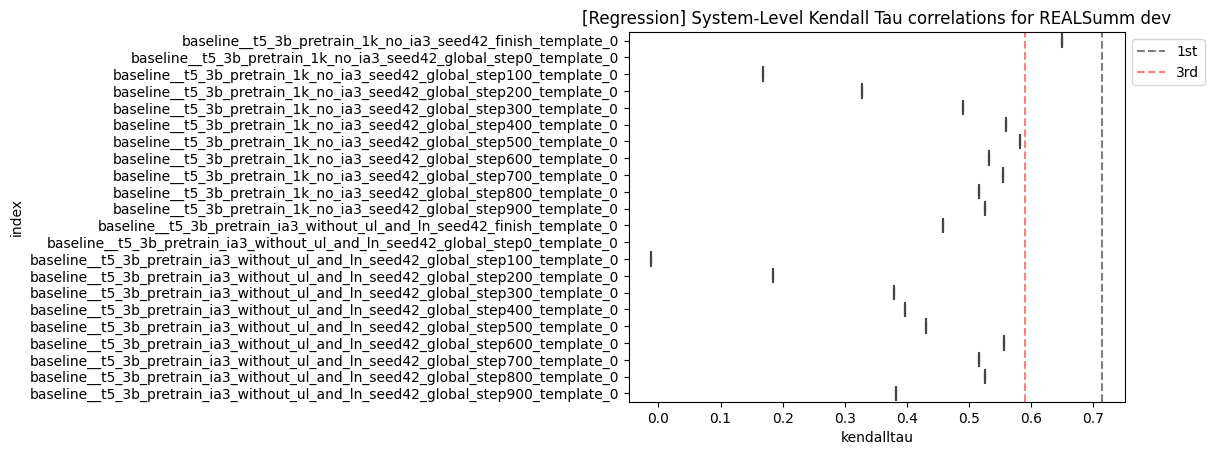

In [33]:
plt.title("[Regression] System-Level Kendall Tau correlations for REALSumm dev")
sns.boxplot(data=system_baseline_corrs, y="index", x="kendalltau")

plt.axvline(x=0.7151, color="black", label="1st", ls="--", alpha=0.5)
# plt.axvline(x=0.62, color="gray", label="rougel_r", ls="--", alpha=0.5)
plt.axvline(x=0.59, color="red", label="3rd", ls="--", alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.00, 1.00))
plt.show()

In [ ]:
sns.boxplot(data=system_baseline_corrs, y="eval_template", x="kendalltau")
#sns.boxplot(data=system_baseline_corrs, y="num_epochs", x="kendalltau")

In [34]:
data[(data["label"] != data["prediction"])]

,idx,label,prediction,log.pred_score,log.label,num_truncated,top5_unconstrained,top5_constrained,current_epoch,index,...,bart_score_cnn_avg_f_de,bart_score_cnn_harm_f_en,bart_score_cnn_harm_f_de,target,bin,label_orig,discretization_type,target_rescaled,len_sys_summ,is_digit_prediction
0,0,19,34,-1.680203,-4.680203,0,"{'tokens': ['▁34', '▁28', '▁23', '▁26', '▁31']...","{'tokens': ['▁34', '▁28', '▁23', '▁26', '▁31']...",0,0,...,-3.338079,-1.568310,-1.667924,36,"(30.62, 42.86]",1,5-quantile,19,76,True
1,1,15,34,-1.738921,-7.551421,0,"{'tokens': ['▁34', '▁28', '▁26', '▁23', '▁42']...","{'tokens': ['▁34', '▁28', '▁26', '▁23', '▁42']...",0,1,...,-3.506089,-1.584143,-1.704337,29,"(-0.01, 30.62]",0,5-quantile,15,90,True
2,2,40,34,-1.421104,-3.046103,0,"{'tokens': ['▁34', '▁42', '▁23', '▁39', '▁40']...","{'tokens': ['▁34', '▁42', '▁23', '▁39', '▁28']...",0,2,...,-2.798319,-1.276288,-1.391062,79,"(62.5, 100.0]",4,5-quantile,40,106,True
3,3,22,34,-1.693933,-3.256433,0,"{'tokens': ['▁34', '▁23', '▁28', '▁40', '▁26']...","{'tokens': ['▁34', '▁23', '▁28', '▁40', '▁26']...",0,3,...,-3.100711,-1.435252,-1.547302,43,"(30.62, 42.86]",1,5-quantile,22,65,True
4,4,8,28,-1.763666,-8.701166,0,"{'tokens': ['▁28', '▁23', '▁26', '▁31', '▁22']...","{'tokens': ['▁28', '▁23', '▁26', '▁31', '▁22']...",0,4,...,-3.518617,-1.643086,-1.758646,14,"(-0.01, 30.62]",0,5-quantile,8,45,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,4,23,-1.230266,-8.855266,0,"{'tokens': ['▁23', '▁26', '▁28', '▁17', '▁19']...","{'tokens': ['▁23', '▁28', '▁26', '▁17', '▁19']...",0,715,...,-3.758921,-1.758243,-1.876409,6,"(-0.01, 30.62]",0,5-quantile,4,65,True
716,716,7,23,-2.207988,-5.207988,0,"{'tokens': ['▁23', '▁28', '▁17', '▁16', '▁12']...","{'tokens': ['▁23', '▁28', '▁17', '▁16', '▁12']...",0,716,...,-3.936838,-1.871848,-1.968171,12,"(-0.01, 30.62]",0,5-quantile,7,86,True
717,717,16,6,-1.915097,-2.477597,0,"{'tokens': ['▁6', '▁1', '▁12', '▁16', '▁17'], ...","{'tokens': ['▁6', '▁1', '▁12', '▁16', '▁17'], ...",0,717,...,-3.992495,-1.894261,-1.996154,31,"(30.62, 42.86]",1,5-quantile,16,64,True
718,718,10,23,-1.516309,-5.641309,0,"{'tokens': ['▁23', '▁28', '▁17', '▁31', '▁26']...","{'tokens': ['▁23', '▁28', '▁17', '▁31', '▁26']...",0,718,...,-4.028410,-1.904063,-2.009883,19,"(-0.01, 30.62]",0,5-quantile,10,74,True


In [35]:
metrics_reg.sort_values("accuracy", ascending=False).head()

,accuracy,digits_count,digits_pct,err_len,err_avg,mae_avg,mse_avg,err_std,mae_std,mse_std,baseline,num_steps,num_epochs,seed,basename
2,0.116667,720,1.0,720,-2.225000,8.819444,129.586111,11.164026,7.197466,173.161368,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,100,0,42,baseline__t5_3b_pretrain_1k_no_ia3
20,0.109722,720,1.0,720,-0.268056,7.918056,116.706944,10.799773,7.349241,224.230862,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,800,6,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln
21,0.105556,720,1.0,720,-0.850000,8.080556,120.908333,10.962930,7.457409,242.540787,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,900,7,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln
11,0.101389,720,1.0,720,-0.690278,8.012500,118.537500,10.865589,7.371387,228.705995,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,1000,8,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln
19,0.100000,720,1.0,720,-0.638889,8.036111,118.658333,10.874289,7.353860,227.934219,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,700,5,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln


In [36]:
metrics_reg

,accuracy,digits_count,digits_pct,err_len,err_avg,mae_avg,mse_avg,err_std,mae_std,mse_std,baseline,num_steps,num_epochs,seed,basename
0,0.090278,720,1.0,720,0.154167,7.843056,108.462500,10.413392,6.851933,193.530270,baseline__t5_3b_pretrain_1k_no_ia3_seed42_fini...,1000,8,42,baseline__t5_3b_pretrain_1k_no_ia3
1,0.000000,720,1.0,720,18.961111,19.177778,487.352778,11.306151,10.934606,486.165976,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,0,0,42,baseline__t5_3b_pretrain_1k_no_ia3
2,0.116667,720,1.0,720,-2.225000,8.819444,129.586111,11.164026,7.197466,173.161368,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,100,0,42,baseline__t5_3b_pretrain_1k_no_ia3
3,0.097222,720,1.0,720,-1.515278,8.237500,120.212500,10.858933,7.235751,205.470965,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,200,1,42,baseline__t5_3b_pretrain_1k_no_ia3
4,0.076389,720,1.0,720,2.595833,8.534722,131.770833,11.181792,7.676545,255.559031,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,300,2,42,baseline__t5_3b_pretrain_1k_no_ia3
5,0.080556,720,1.0,720,-1.086111,8.830556,135.775000,11.601524,7.602387,255.114499,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,400,3,42,baseline__t5_3b_pretrain_1k_no_ia3
6,0.079167,720,1.0,720,1.988889,8.525000,132.797222,11.350839,7.753812,266.342533,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,500,4,42,baseline__t5_3b_pretrain_1k_no_ia3
7,0.080556,720,1.0,720,-0.313889,8.186111,116.980556,10.811199,7.068815,207.397718,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,600,5,42,baseline__t5_3b_pretrain_1k_no_ia3
8,0.066667,720,1.0,720,0.252778,8.563889,127.730556,11.298967,7.374982,229.750776,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,700,5,42,baseline__t5_3b_pretrain_1k_no_ia3
9,0.081944,720,1.0,720,-1.213889,8.311111,119.850000,10.880095,7.125688,210.646649,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,800,6,42,baseline__t5_3b_pretrain_1k_no_ia3


In [37]:
metrics_reg["eval_template"] = metrics_reg["baseline"].apply(extract_template)
metrics_reg["basename"] = metrics_reg["baseline"].apply(extract_basename)
metrics_reg.tail()

,accuracy,digits_count,digits_pct,err_len,err_avg,mae_avg,mse_avg,err_std,mae_std,mse_std,baseline,num_steps,num_epochs,seed,basename,eval_template
17,0.086111,720,1.0,720,-2.859722,8.904167,135.015278,11.262205,7.465326,241.113818,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,500,4,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,0
18,0.084722,720,1.0,720,-0.491667,7.975000,116.175000,10.767231,7.250819,222.819010,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,600,5,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,0
19,0.100000,720,1.0,720,-0.638889,8.036111,118.658333,10.874289,7.353860,227.934219,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,700,5,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,0
20,0.109722,720,1.0,720,-0.268056,7.918056,116.706944,10.799773,7.349241,224.230862,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,800,6,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,0
21,0.105556,720,1.0,720,-0.850000,8.080556,120.908333,10.962930,7.457409,242.540787,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,900,7,42,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,0


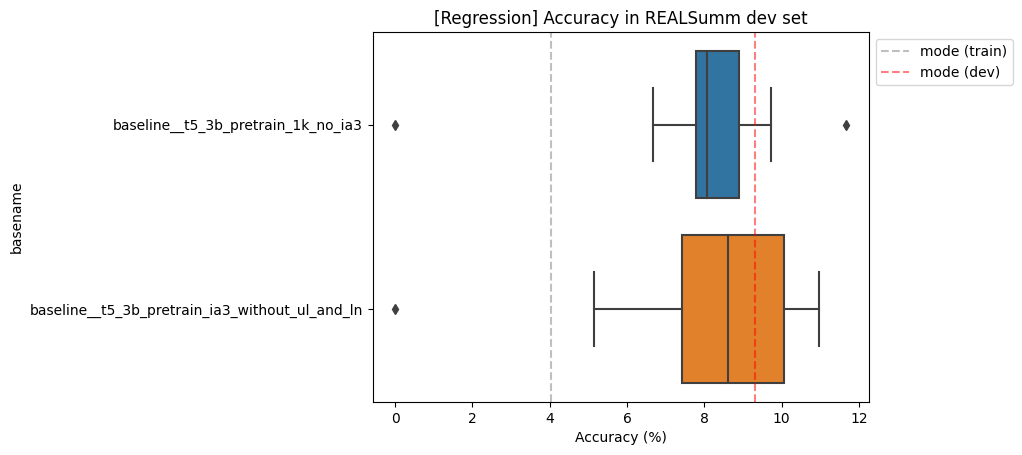

In [45]:
metrics_reg["Accuracy (%)"] = metrics_reg["accuracy"].apply(lambda l: round(l*100, 2))

plt.title("[Regression] Accuracy in REALSumm dev set")
sns.boxplot(data=metrics_reg, y="basename", x="Accuracy (%)")

train_mode = round((dev_df["target_rescaled"] == 23).sum() / len(dev_df) * 100, 2)
dev_mode = round((dev_df["target_rescaled"] == 26).sum() / len(dev_df) * 100, 2)

plt.axvline(x=train_mode, color="gray", label="mode (train)", ls="--", alpha=0.5)
plt.axvline(x=dev_mode, color="red", label="mode (dev)", ls="--", alpha=0.5)

plt.legend(loc='upper left', bbox_to_anchor=(1.00, 1.00))
plt.show()

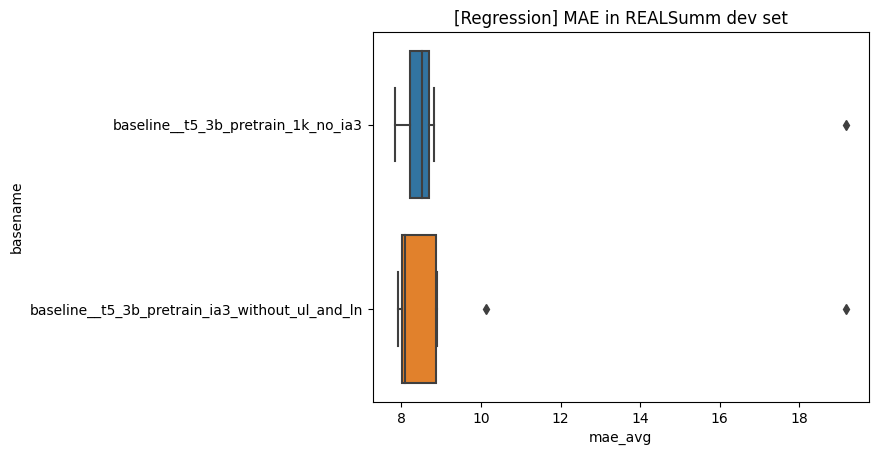

In [78]:
plt.title("[Regression] MAE in REALSumm dev set")
sns.boxplot(data=metrics_reg, y="basename", x="mae_avg")

train_mode = round((dev_df["target_rescaled"] == 23).sum() / len(dev_df) * 100, 2)
dev_mode = round((dev_df["target_rescaled"] == 26).sum() / len(dev_df) * 100, 2)

plt.show()

In [61]:
top_accurate = metrics_reg.sort_values(["Accuracy (%)"], ascending=False)[["baseline", "basename", "num_epochs", "num_steps", "Accuracy (%)"]].head()
top_accurate

,baseline,basename,num_epochs,num_steps,Accuracy (%)
2,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,baseline__t5_3b_pretrain_1k_no_ia3,0,100,11.67
20,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,6,800,10.97
21,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,7,900,10.56
11,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,8,1000,10.14
19,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,5,700,10.00


In [71]:
top_accurate_ids = top_accurate["baseline"].unique()
top_accurate_data = {}
for i, top_acc_id in enumerate(top_accurate_ids):
    d = dev_baselines[top_acc_id]
    print(top_acc_id, "\n -->", d.prediction.unique(), "\n") # --> majority classes
    
    top_accurate_data[i] = d

baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step100_template_0 
 --> [26 22 28 23 12  1] 

baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step800_template_0 
 --> [28 34 23 26 20 22 31 16 40 17 12 19  6  1] 

baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step900_template_0 
 --> [34 28 23 26 20 22 31 16 43 40 12 19 17  6  1] 

baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_finish_template_0 
 --> [28 34 23 26 20 22 31 43 16 40 12 19 17  6  1] 

baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step700_template_0 
 --> [28 34 23 26 22 31 16  6 20 40 12 19 17  1] 



In [72]:
top_accurate_data[4].groupby("bartscore_doc_id").std()

,idx,label,prediction,log.pred_score,log.label,num_truncated,current_epoch,index,litepyramid_recall,bert_score_p,...,bart_score_cnn_hypo_ref_de,bart_score_cnn_avg_f_en,bart_score_cnn_avg_f_de,bart_score_cnn_harm_f_en,bart_score_cnn_harm_f_de,target,label_orig,target_rescaled,len_sys_summ,is_digit_prediction
bartscore_doc_id,,,,,,,,,,,,,,,,,,,,,
6,7.071068,5.980039,6.070689,0.202901,0.913279,0.0,0.0,7.071068,0.121570,0.101310,...,0.398164,0.360500,0.342420,0.189156,0.176907,12.161951,0.850192,5.980039,30.098389,0.0
13,7.071068,8.971775,5.199638,0.249965,0.926813,0.0,0.0,7.071068,0.178969,0.060236,...,0.395371,0.288467,0.270791,0.157813,0.141993,17.956419,1.282547,8.971775,17.882416,0.0
16,7.071068,7.465743,4.316928,0.107655,1.567107,0.0,0.0,7.071068,0.150441,0.092902,...,0.350497,0.358392,0.347657,0.176330,0.170511,15.113999,1.244553,7.465743,15.780882,0.0
22,7.071068,7.959021,3.670288,0.144871,0.971325,0.0,0.0,7.071068,0.162109,0.100140,...,0.249015,0.301384,0.282735,0.145093,0.137210,16.465984,1.301476,7.959021,16.051547,0.0
24,7.071068,6.055301,1.411649,0.193019,1.182078,0.0,0.0,7.071068,0.124069,0.106416,...,0.279119,0.365710,0.347843,0.173212,0.165500,12.689149,1.049500,6.055301,18.458679,0.0
26,7.071068,11.298005,2.245366,0.295854,1.179384,0.0,0.0,7.071068,0.229159,0.110991,...,0.306906,0.340039,0.326928,0.168567,0.161466,23.114985,1.503016,11.298005,15.561705,0.0
27,7.071068,12.914364,3.105628,0.125882,1.426817,0.0,0.0,7.071068,0.263862,0.103077,...,0.436915,0.332514,0.319387,0.179651,0.169185,26.464496,1.366658,12.914364,44.918263,0.0
29,7.071068,10.356595,4.510053,0.217574,1.640537,0.0,0.0,7.071068,0.208943,0.095588,...,0.475694,0.453090,0.428560,0.226240,0.213680,21.014445,1.293798,10.356595,18.222011,0.0
32,7.071068,6.868195,2.339020,0.227329,1.560612,0.0,0.0,7.071068,0.135666,0.079230,...,0.138746,0.333889,0.315213,0.171127,0.158113,13.535715,1.095941,6.868195,17.186952,0.0


In [114]:
idd = 0
ex_constant_pred = top_accurate_data[idd][top_accurate_data[idd]["bartscore_doc_id"] == 96].sort_values("label")

count = 0
for i, example in ex_constant_pred.iterrows():
    if count == 0:
        print("[Document]:\n", example["src"])
        print("\n\n", "--" * 50, "\n\n")
        print("[Reference summary]:\n", example["ref_summ"])
        print("\n\n", "==" * 50, "\n\n")
    
    sys_name = example["sys_name"].replace("out_", "").replace(".txt", "")
    print(f"[Generated summary {i}, {sys_name}] Human score: {example['label']} \t Predicted score: {example['prediction']}")
    print(example["sys_summ"])
    print("--" * 50, "\n")
    count += 1
    # if count > 5:
    #     break

[Document]:
 I spoke to carl froch for an hour this week and we have talked long and hard about what he is going to do next . Needless to say , we were disappointed to see julio cesar chavez jnr lose at the weekend against andrzej fonfara . It wasn ’ t a result we were expecting and it also blows away the chance of froch and chavez fighting in las vegas – a fight carl wanted . Now we turn to three big fights in the next two months to see what carl does next . I have held talks with gennady golovkin ’ s manager and there is also the possibility of bernard hopkins , but there are three fights coming up where the winner could work for carl . Carl froch ( left ) has not fought since beating george groves at wembley last may . Froch has kept in shape and weighs 12st 7lbs - despite being away from the ring for nearly a year now . Froch had hoped to meet julio cesar chavez jr , but he lost to andrzej fonfara last week . There is the possibility of paul smith-andre ward in the pipeline , antho

In [115]:
top_accurate_ids

array(['baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step100_template_0',
       'baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step800_template_0',
       'baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step900_template_0',
       'baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_finish_template_0',
       'baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step700_template_0'],
      dtype=object)

In [116]:
best_mae_ids

array(['baseline__t5_3b_pretrain_1k_no_ia3_seed42_finish_template_0',
       'baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step900_template_0',
       'baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step800_template_0',
       'baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step600_template_0',
       'baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_finish_template_0'],
      dtype=object)

### BEST MAE

In [84]:
best_mae = metrics_reg.sort_values(["mae_avg"], ascending=True)[["baseline", "basename", "num_epochs", "num_steps", "mae_avg", "Accuracy (%)"]].head()
best_mae

,baseline,basename,num_epochs,num_steps,mae_avg,Accuracy (%)
0,baseline__t5_3b_pretrain_1k_no_ia3_seed42_fini...,baseline__t5_3b_pretrain_1k_no_ia3,8,1000,7.843056,9.03
10,baseline__t5_3b_pretrain_1k_no_ia3_seed42_glob...,baseline__t5_3b_pretrain_1k_no_ia3,7,900,7.869444,8.75
20,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,6,800,7.918056,10.97
18,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,5,600,7.975000,8.47
11,baseline__t5_3b_pretrain_ia3_without_ul_and_ln...,baseline__t5_3b_pretrain_ia3_without_ul_and_ln,8,1000,8.012500,10.14


In [87]:
best_mae_ids = best_mae["baseline"].unique()
best_mae_data = {}
for i, best_mae_id in enumerate(best_mae_ids):
    d = dev_baselines[best_mae_id]
    print(best_mae_id, "\n -->", d.prediction.unique(), "\n") # --> majority classes
    
    best_mae_data[i] = d

baseline__t5_3b_pretrain_1k_no_ia3_seed42_finish_template_0 
 --> [34 17 32 35 23 26 28 19 12 16 42 22 38 20 45 39 31  6 21 15  5 14 29 37
 30  1 13] 

baseline__t5_3b_pretrain_1k_no_ia3_seed42_global_step900_template_0 
 --> [34 17 32 35 23 22 16 26 28 19 12 42 38 20 39 45 21 31  6 14 15  5 29  1
 30 13] 

baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step800_template_0 
 --> [28 34 23 26 20 22 31 16 40 17 12 19  6  1] 

baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step600_template_0 
 --> [34 28 23 22 20 16 26 40 12 19 17  6  1 31] 

baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_finish_template_0 
 --> [28 34 23 26 20 22 31 43 16 40 12 19 17  6  1] 



In [103]:
idd = 0
best_mae_data[idd]["abs_err"] = np.abs(best_mae_data[idd]["prediction"] - best_mae_data[idd]["label"])
best_mae_data[idd].sort_values("abs_err", ascending=False)[["bartscore_doc_id", "idx", "ref_summ", "sys_summ", "sys_name", "target_rescaled", "prediction"]].head(20)

,bartscore_doc_id,idx,ref_summ,sys_summ,sys_name,target_rescaled,prediction
478,96,478,If Carl Froch does n't fight in 2015 I 'm not ...,Froch has kept in shape and weighs 12st 7lbs -...,matchsumm_out.txt,50,6
471,96,471,If Carl Froch does n't fight in 2015 I 'm not ...,James degale ( right ) has now emerged as the ...,pnbert_out_lstm_pn_rl.txt,50,12
474,96,474,If Carl Froch does n't fight in 2015 I 'm not ...,Carl froch ( left ) has not fought since beati...,pnbert_out_bert_tf_sl.txt,50,12
477,96,477,If Carl Froch does n't fight in 2015 I 'm not ...,Carl froch ( left ) has not fought since beati...,pnbert_out_bert_tf_pn.txt,50,12
258,45,258,Justin Rose finished joint runner - up at the ...,Justin rose was unable to take victory at the ...,pnbert_out_bert_tf_sl.txt,50,14
472,96,472,If Carl Froch does n't fight in 2015 I 'm not ...,"Needless to say , we were disappointed to see ...",refresh_out.txt,50,16
462,96,462,If Carl Froch does n't fight in 2015 I 'm not ...,Carl Froch has been out of the ring since beat...,bart_out.txt,50,17
263,45,263,Justin Rose finished joint runner - up at the ...,Justin rose was unable to take victory at the ...,pnbert_out_bert_lstm_pn.txt,50,17
246,45,246,Justin Rose finished joint runner - up at the ...,Justin Rose finished second at the Masters des...,bart_out.txt,50,17
598,63,598,ONE Pro Cycling preparing to take on Team Sky ...,Matt prior 's one pro cycling team has been co...,matchsumm_out.txt,36,6


In [110]:
ex_constant_pred = best_mae_data[idd][best_mae_data[idd]["bartscore_doc_id"] == 96].sort_values("label")

count = 0
for i, example in ex_constant_pred.iterrows():
    if count == 0:
        print("[Document]:\n", example["src"])
        print("\n\n", "--" * 50, "\n\n")
        print("[Reference summary]:\n", example["ref_summ"])
        print("\n\n", "==" * 50, "\n\n")
    
    sys_name = example["sys_name"].replace("out_", "").replace(".txt", "")
    print(f"[Generated summary {i}, {sys_name}] Human score: {example['label']} \t Predicted score: {example['prediction']}")
    print(example["sys_summ"])
    print("--" * 50, "\n")
    count += 1
    # if count > 15:
    #     break
        

[Document]:
 I spoke to carl froch for an hour this week and we have talked long and hard about what he is going to do next . Needless to say , we were disappointed to see julio cesar chavez jnr lose at the weekend against andrzej fonfara . It wasn ’ t a result we were expecting and it also blows away the chance of froch and chavez fighting in las vegas – a fight carl wanted . Now we turn to three big fights in the next two months to see what carl does next . I have held talks with gennady golovkin ’ s manager and there is also the possibility of bernard hopkins , but there are three fights coming up where the winner could work for carl . Carl froch ( left ) has not fought since beating george groves at wembley last may . Froch has kept in shape and weighs 12st 7lbs - despite being away from the ring for nearly a year now . Froch had hoped to meet julio cesar chavez jr , but he lost to andrzej fonfara last week . There is the possibility of paul smith-andre ward in the pipeline , antho

<AxesSubplot:xlabel='len_sys_summ', ylabel='prediction'>

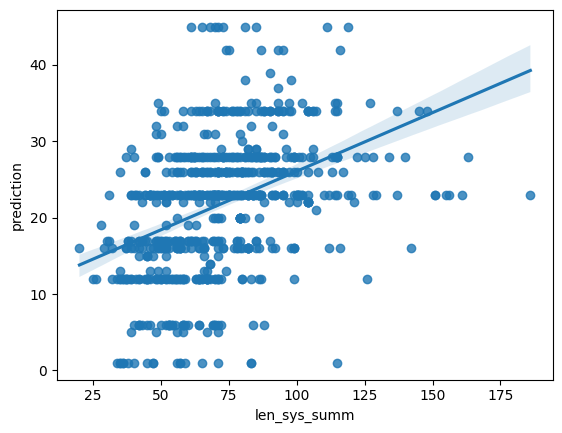

In [90]:
sns.regplot(data=best_mae_data[0], x="len_sys_summ", y="prediction")

<AxesSubplot:xlabel='len_sys_summ', ylabel='label'>

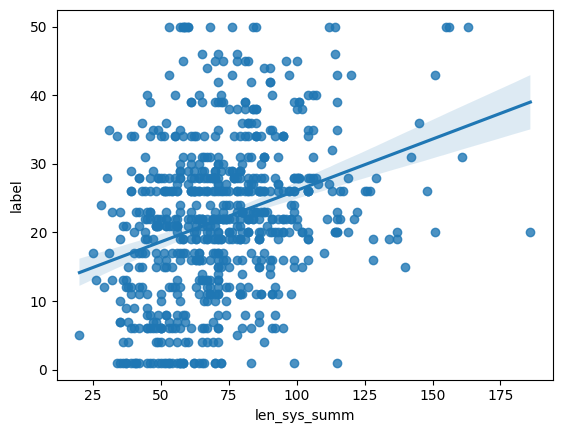

In [91]:
sns.regplot(data=best_mae_data[0], x="len_sys_summ", y="label")


## Easy examples

- [ ] Check easy examples (e.g., std of human scores for the )
- [ ] Check difficult examples (e.g., std of human scores for the same 
    reference is smaller)
- [ ] Check examples with lowest human score (is that a reasonable score)? (examine a few sampled examples in lowest 5%)
- [ ] Check examples with highest human score (is that a reasonable score)? (examine a few sampled examples in lowest 5%)
- [ ] Rouge 1 (R), extreme examples (larger gap to human score, close to 0, close to 1)
- [ ] Rouge 2 (R), extreme examples (larger gap to human score, close to 0, close to 1)
- [ ] T5 results (larger gap to human score, close to 0, close to 1)


## Easy examples

- [ ] Check examples with lowest human score (is that a reasonable score)? (examine a few sampled examples in lowest 5%)
- [ ] Check examples with highest human score (is that a reasonable score)? (examine a few sampled examples in lowest 5%)
- [ ] Check easy examples (e.g., std of human scores for the same example)
- [ ] Check difficult examples (e.g., std of human scores for the same 
    reference is smaller)
- [ ] Rouge 1 (R), extreme examples (larger gap to human score, close to 0, close to 1)
- [ ] Rouge 2 (R), extreme examples (larger gap to human score, close to 0, close to 1)
- [ ] T5 results (larger gap to human score, close to 0, close to 1)

In [ ]:
print("\n" * 2)
print("TRAIN")
print("\n" * 2)
lower_scores = train_df.sort_values("target_rescaled").head(50)
higher_scores = train_df.sort_values("target_rescaled").tail(50)

print("=========== LOWER  HUMAN SCORES ===========")
print("Unique (BARTScore document) ids:", lower_scores.bartscore_doc_id.tolist())
print(lower_scores.bartscore_doc_id.value_counts())

print("=========== HIGHER  HUMAN SCORES ===========")
print("Unique (BARTScore document) ids:", higher_scores.bartscore_doc_id.tolist())
print(higher_scores.bartscore_doc_id.value_counts())


    
# bartscore_doc_id uniquely identifies each document id 
print("[Human]")
low_human_std_top, high_human_std_top = get_extremes_for_metric(train_df, "target_rescaled", by="bartscore_doc_id")

# bartscore_doc_id uniquely identifies each document id 
print("[Rouge1-R]")
low_rouge1_std_top, high_rouge1_std_top = get_extremes_for_metric(train_df, "rouge1_r", by="bartscore_doc_id")

print("[Rouge2-R]")
low_rouge2_std_top, high_rouge2_std_top = get_extremes_for_metric(train_df, "rouge2_r", by="bartscore_doc_id")

In [ ]:
print("\n" * 2)
print("DEV")
print("\n" * 2)
lower_scores = dev_df.sort_values("target_rescaled").head(50)
higher_scores = dev_df.sort_values("target_rescaled").tail(50)

print("=========== LOWER  HUMAN SCORES ===========")
print("Unique (BARTScore document) ids:", lower_scores.bartscore_doc_id.tolist())
print(lower_scores.bartscore_doc_id.value_counts())

print("=========== HIGHER  HUMAN SCORES ===========")
print("Unique (BARTScore document) ids:", higher_scores.bartscore_doc_id.tolist())
print(higher_scores.bartscore_doc_id.value_counts())

# bartscore_doc_id uniquely identifies each document id 
print("[Human]")
low_human_std_top, high_human_std_top = get_extremes_for_metric(dev_df, "target_rescaled", by="bartscore_doc_id")

# bartscore_doc_id uniquely identifies each document id 
print("[Rouge1-R]")
low_rouge1_std_top, high_rouge1_std_top = get_extremes_for_metric(dev_df, "rouge1_r", by="bartscore_doc_id")

print("[Rouge2-R]")
low_rouge2_std_top, high_rouge2_std_top = get_extremes_for_metric(dev_df, "rouge2_r", by="bartscore_doc_id")

In [ ]:
sns.set_style("whitegrid")

    
def plot_kde_stack(data, bartscore_id, target_col="litepyramid_recall", metric_col="rouge2_r"):
    d = data[data["bartscore_doc_id"] == bartscore_id].sort_values("sys_name").copy()

    d1 = d[["index", "bartscore_doc_id", target_col]].copy()
    d1.columns = d1.columns[:-1].tolist() + ["value"]
    d1["metric"] = target_col
    d2 = d[["index", "bartscore_doc_id", metric_col]].copy()
    d2.columns = d2.columns[:-1].tolist() + ["value"]
    d2["metric"] = metric_col


    d1d2 = pd.concat((d1, d2))
    sns.kdeplot(data=d1d2, x="value", hue="metric", multiple="stack", fill=True, common_norm=True, alpha=0.4)
    sns.despine()
    
    
def plot_distributions_per_doc(data, bartscore_id, target_col="target_rescaled", metric_col="rouge2_r"):
    d = data[data["bartscore_doc_id"] == bartscore_id].sort_values("sys_name").copy()

    corr, corr_pval = kendalltau(d[target_col], d["rouge2_r"])
    print("Kendalltau:", corr, "\t| p_val =", corr_pval)

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 6), tight_layout=True)

    # plot stacked density distributions of variables
    sns.barplot(data=d, y="sys_name", x=target_col, alpha=0.5, ax=axes[0])
    sns.barplot(data=d, y="sys_name", x=metric_col, alpha=0.5, ax=axes[1])
    plt.show()

    # plot stacked density distributions of variables
    sns.lineplot(data=d, x="sys_name", y=target_col, alpha=0.5, color="black", label=target_col)
    sns.lineplot(data=d, x="sys_name", y=metric_col, alpha=0.5, color="red", label=metric_col)
    plt.xticks(rotation=90);
    plt.show()

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5), tight_layout=True)
    # plot stacked density distributions of variables
    sns.kdeplot(data=d, x=target_col, alpha=0.5, ax=axes[0])
    sns.kdeplot(data=d, x=metric_col, alpha=0.5, ax=axes[1])
    plt.show()

In [ ]:
plot_kde_stack(train_df, 50)
plot_distributions_per_doc(train_df, 50, "litepyramid_recall", "rouge2_r")

In [ ]:
plot_kde_stack(dev_df, 63, "litepyramid_recall", "rouge1_r")
plot_distributions_per_doc(dev_df, 63, "litepyramid_recall", "rouge1_r")

In [ ]:
# Analysis of scores by instance
# baseline_preds = dev_baselines["baseline_ia3_pretrained100k_ft_train_ia3_template_7"]
baseline_preds = dev_baselines["baseline__t5_3b_pretrain_1k_no_ia3_seed42_finish_template_0"]
baseline_preds.groupby("bartscore_doc_id").std().sort_index()

In [ ]:
ex_constant_pred = baseline_preds[baseline_preds["bartscore_doc_id"] == 6]

count = 0
for i, example in ex_constant_pred.iterrows():
    if count == 0:
        print("[Document]:\n", example["src"])
        print("\n\n", "--" * 50, "\n\n")
        print("[Reference summary]:\n", example["ref_summ"])
        print("\n\n", "==" * 50, "\n\n")
        
    print(f"[Generated summary {i}] Human score: {example['label']} \t Predicted score: {example['prediction']}")
    print(example["sys_summ"])
    print("--" * 50, "\n")
    count += 1
    if count > 5:
        break
        
print(ex_constant_pred["label"].mean())
ex_constant_pred["label"].plot(kind="hist", bins=50, range=(1, 51))

In [ ]:
instance_baseline_corrs.sort_values("kendalltau", ascending=False).head()

In [ ]:
d = dev_baselines["baseline__t5_3b_pretrain_ia3_without_ul_and_ln_seed42_global_step400_template_0"].copy()
d["proba.score"] = d["log.pred_score"].apply(np.exp)
sns.histplot(data=d, x="proba.score")

print(d.prediction.value_counts())
print(d.label.value_counts())